In [1]:
# example purpose only
import sys
sys.path.append('../')
from src import ht2

## prepare data

100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4801.06it/s]


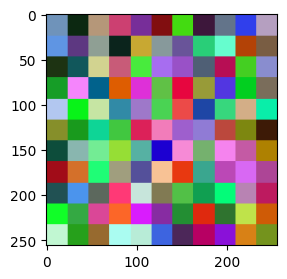

In [3]:
# lmdb image packer
from tqdm import tqdm
import numpy as np
import os
from os.path import join
import cv2
from uuid import uuid4

# step up
tmp_data_path = "/data/ht2_tmp/lmdb/"
tmp_imgs_path = join(tmp_data_path,"imgs")
os.makedirs(tmp_imgs_path,exist_ok=True)

# create image bag
tiny_imgs = []
for i in tqdm(range(10000)): # 5GB mem
    img_id = str(uuid4())
    tiny_img = np.random.randint(256, size=[11,11,3],dtype=np.uint8)
    tiny_img = cv2.resize(tiny_img,(256,256),interpolation=cv2.INTER_NEAREST)
    tiny_imgs.append({"id":img_id,
                      "img":tiny_img,
                      "label":str(np.sum(tiny_img))}
                      )
# show example image
ht2.show_img_np(tiny_imgs[0]["img"])


In [4]:
ht2.export_lmdb(tiny_imgs, export_path = join(tmp_data_path,"tiny_imgs"), encoder=lambda x: ht2.smart_encode_from_key(x))

In [5]:
from os.path import join
tmp_data_path = "/data/ht2_tmp/lmdb/"
data_list = ht2.import_lmdb(join(tmp_data_path,"tiny_imgs"),decoder = lambda x: ht2.smart_decode_from_key(x))

In [27]:
import lmdb

data_dir = join(tmp_data_path,"tiny_imgs")
lmdb_env = lmdb.open(data_dir)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()

for key, value in tqdm(lmdb_cursor):
    pass

300000it [00:00, 1557225.56it/s]


In [29]:
# test regular jpg save
from time import time
import uuid
from os.path import join
import cv2
from glob import glob
## test save jpgs time
t = time()
for data in tqdm(tiny_imgs):
    img_id = str(uuid.uuid4())
    path = join(tmp_data_path,"imgs",img_id+".jpg")
    cv2.imwrite(path,
                data['img'],
                [cv2.IMWRITE_JPEG_OPTIMIZE, int(True), cv2.IMWRITE_JPEG_QUALITY, 95])
print("[time] save jpgs: ",time()-t)
print("[size] img folder size: {:.4f} MB".format(ht2.get_folder_size(tmp_imgs_path)/1024/1024))
# test load jpgs time
t = time()
loaded_imgs = []
for path in tqdm(glob(join(tmp_imgs_path,"*.jpg"))):
    loaded_imgs.append(cv2.imread(path))
print("[time] load jpgs: ",time()-t)





100%|██████████████████████████████████| 100000/100000 [05:14<00:00, 318.03it/s]


[time] save jpgs:  314.4493751525879
[size] img folder size: 1428.4047 MB


100%|██████████████████████████████████| 100000/100000 [02:38<00:00, 630.23it/s]


[time] load jpgs:  159.0635175704956
zipping... 
[time] zip imgs: 67.1841s
[size] zip size: 1426.8286 MB
[time] unzip imgs: 26.3767s


In [7]:
import shutil
shutil.rmtree(tmp_data_path)


In [35]:
print("{:.4f} MB".format(get_size(tmp_imgs_path)/1024/1024))



output_folder = "tmp_data_path"

os.makedirs(outputPath, exist_ok=True)
env = lmdb.open(outputPath, map_size=2**40)

cache = {}
cnt = 1


nSamples = len(labels)
for i, line in tqdm(enumerate(labels)):
    imagePath, label = line


    imageKey = str(uuid.uuid)
    labelKey = 'label-%09d'.encode() % cnt
    cache[imageKey] = imageBin
    cache[labelKey] = label.encode()

    if cnt % 100000 == 0:
        writeCache(env, cache)
        cache = {}
        print('Written %d / %d' % (cnt, nSamples))bb
    cnt += 1
nSamples = cnt - 1
cache['num-samples'.encode()] = str(nSamples).encode()
writeCache(env, cache)
env.close()
print('Created dataset with %d samples' % nSamples)



409.4754 MB
zipping... 
[time] zip imgs: 10.5530s
[size] zip size: 410.9881 MB
[time] unzip imgs: 0.0498s


replace data/ht2_tmp/lmdb/imgs/105c5664-0dcd-4b88-873d-1f20061a7a38.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [ ]:
import ht2
import json
from os.path import join, exists
import cv2
from tqdm import tqdm
import re
import os
import random
random.seed(123)
import io
import os
import lmdb
import numpy as np
from PIL import Image
from tools.data_gen_ops import *
from glob import glob



# configs
blocked_chars = ["\\cdots","\cmark","\\textcircled","\\frac","<unk>"]
basic_chars = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
replace_dict = {"\\deletion":" ",
                "\\tab":"\\",
                "\\prime":"\'",
                "\\[":"[",
                "\\]":"]",
                "\\(":"(",
                "\\)":")",
                "、":",",
                "\\xmark":"x",
                "\$":"$",
                "\\times":"x",
                "{":"",
                "}":"",
                "\\insert":" ",
                "\\grave":" ",
                "《":"< <",
                "》":"> >",
                "。":".",
                "\%":"%",
               }

def classic_tr_data_to_label(json_path, img_root, ext):
    print(json_path)
    data = json.load(open(json_path, 'r'))
    labels = []
    for img_id,label in tqdm(list(data.items())[:]):
        img_path = join(img_root,img_id+"."+ext)
        if not exists(img_path):
            img_path = join(img_root,img_id+"_move."+ext)
        if not exists(img_path):
            img_path = join(img_root,img_id+"_touch."+ext)
        if not exists(img_path):
            img_path = join(img_root,img_id+"_overlap."+ext)
        if not exists(img_path):
            print("not exist: ", img_path)
            continue        
        # print(label)
        if type(label) == dict:
            raw_label = label["label"]
        else:
            raw_label = label
        for orig,target in replace_dict.items():
            raw_label = raw_label.replace(orig,target)
        orig_chars = raw_label.split(" ")
        
        select_label = True
        for char in orig_chars:
            if is_chinese_char(char):
                select_label = False
                continue
            if char in blocked_chars:
                select_label = False
                continue
            if char not in basic_chars:
                # print(label["label"])
                # img = cv2.imread(img_path)
                # ht2.show_img_np(img)
                select_label = False
                break
        if select_label:
            raw_label = raw_label.replace(" ","")
            raw_label = raw_label.replace("\\"," ")
            raw_label = re.sub('([.,!?()])', r'\1 ', raw_label)
            raw_label = re.sub('\s{2,}', ' ', raw_label)
            re.sub('\?[A-Z]', '\? ', raw_label)
            raw_label = raw_label.replace(" ","_")
            # print(raw_label)
            labels.append([img_path,raw_label]) 
    return labels

data_list = [
             ["/data/eng_word_gen_ims_htx_0525/0.json","/data/eng_word_gen_ims_htx_0525/images/","jpg"],
             ["/data/eng_word_gen_ims_htx_0525/1.json","/data/eng_word_gen_ims_htx_0525/images/","jpg"],
             ["/data/eng_word_gen_ims_htx_0525/2.json","/data/eng_word_gen_ims_htx_0525/images/","jpg"],
             ["/data/eng_word_gen_ims_htx_0525/3.json","/data/eng_word_gen_ims_htx_0525/images/","jpg"],
             ["/data/eng_word_gen_ims_htx_0525/4.json","/data/eng_word_gen_ims_htx_0525/images/","jpg"],
             ["/data/eng_word_gen_ims_htx_0525/5.json","/data/eng_word_gen_ims_htx_0525/images/","jpg"],
    
            ["/data/eng_data/train_english_combined.json","/data/eng_data/train_english/","png"],
                     ["/data/eng_data/plabel_eng_prod.json","/data/eng_data/plabel_eng_prod/","jpg"]
            ]

labels = []
for json_path, img_root, ext in data_list:
    labels+=(classic_tr_data_to_label(json_path, img_root, ext))
    print(len(labels))
random.shuffle(labels)





# TODO streamline this
def save_data(outputPath,labels):
    checkValid = True
    os.makedirs(outputPath, exist_ok=True)
    env = lmdb.open(outputPath, map_size=1099511627776)

    cache = {}
    cnt = 1


    nSamples = len(labels)
    for i, line in tqdm(enumerate(labels)):
        imagePath, label = line

        if checkValid:
            try:
                with open(imagePath, 'rb') as f:
                    imageBin = f.read()
                img = Image.open(io.BytesIO(imageBin)).convert('RGB')
            except:
                with open(outputPath + '/error_image_log.txt', 'a') as log:
                    log.write('{}-th image data occured error: {}, {}\n'.format(i, imagePath, ""))
                print("bad image", imagePath)
                continue
            if np.prod(img.size) == 0:
                print('%s is not a valid image' % imagePath)
                continue

        imageKey = 'image-%09d'.encode() % cnt
        labelKey = 'label-%09d'.encode() % cnt
        cache[imageKey] = imageBin
        cache[labelKey] = label.encode()

        if cnt % 100000 == 0:
            writeCache(env, cache)
            cache = {}
            print('Written %d / %d' % (cnt, nSamples))
        cnt += 1
    nSamples = cnt - 1
    cache['num-samples'.encode()] = str(nSamples).encode()
    writeCache(env, cache)
    env.close()
    print('Created dataset with %d samples' % nSamples)

save_data("/data/parseq_train_04/train/real/",labels[:-20000])
save_data("/data/parseq_train_04/val/",labels[-20000:-10000])
save_data("/data/parseq_train_04/test/",labels[-10000:])


